# Generative AI

In this notebook, Generative Adversarial Networks (GAN) will be used to create new images.

* Train GAN for MNIST (1,5P)
* Apply GAN on Fashion MNIST (1P)
* Apply GAN on another dataset (1,5P)

## GAN - MNIST

Train a GAN network to create new instances of the MNIST dataset. You can follow a tutorial such as [Example Tutorial](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) to complete this task. However, it is important that you comment your code and describe your observations. 

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


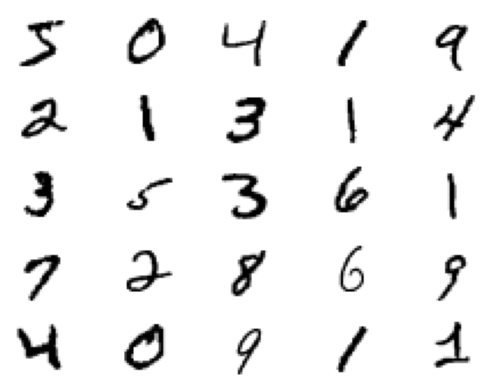

In [4]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot

(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

for i in range(25):
 pyplot.subplot(5, 5, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [11]:
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model
from numpy import expand_dims
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy.random import randn
from numpy.random import rand
from numpy.random import randint
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from matplotlib import pyplot

In [23]:
# define the standalone discriminator model
# takes image as an input and classifies if real or fake
# mutliple layers, after conv2d layer comes an activation function
def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

# load and prepare mnist training images
def load_real_samples():
 (trainX, _), (_, _) = load_data()
 # cond2d needs 3d data, expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X


# a function that selects real saamples from the dataset
def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = randint(0, dataset.shape[0], n_samples)
 # retrieve selected images
 X = dataset[ix]
 # generate 'real' class labels (1), label that indicates if sample is real or fake
 y = ones((n_samples, 1))
 return X, y


# generate n fake samples with class labels, generating random fake samples
def generate_fake_samples_mock(n_samples):
 # generate uniform random numbers in [0,1]
 X = rand(28 * 28 * n_samples)
 # reshape into a batch of grayscale images
 X = X.reshape((n_samples, 28, 28, 1))
 # generate 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

def train_discriminator_with_mock(model, dataset, n_iter=100, n_batch=256):
 half_batch = int(n_batch / 2)
 # half of batch is real and half is fake samples
 # manually enumerate epochs
 for i in range(n_iter):
  # get randomly selected 'real' samples
  X_real, y_real = generate_real_samples(dataset, half_batch)
 # update discriminator on real samples
  _, real_acc = model.train_on_batch(X_real, y_real)
 # generate 'fake' examples
  X_fake, y_fake = generate_fake_samples_mock(half_batch)
  # update discriminator on fake samples
  _, fake_acc = model.train_on_batch(X_fake, y_fake)
  # summarize performance
  print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [25]:
disc_model = define_discriminator()
disc_model.summary()
plot_model(disc_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

dataset = load_real_samples()
train_discriminator_with_mock(disc_model, dataset)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 3136)             

In [32]:
# define the standalone generator model
# generator models is trained to generate fake samples
# fakes should be so good that discriminator cannot tell that they are fake
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

# to generate samples with generator, takes latent vector as input
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 X = g_model.predict(x_input)
 # create 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                          

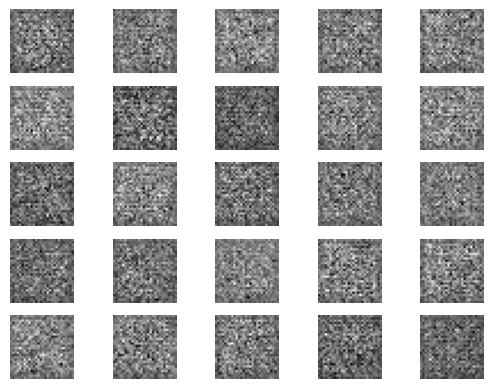

images produced seem really fake/random, untrained generator model does not produce plausible images


In [35]:
# creating samples with untrained generator model

latent_dim = 100
gen_model = define_generator(latent_dim)
gen_model.summary()
plot_model(gen_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
n_samples = 25
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis labels
 pyplot.axis('off')
 # plot single image
 pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

print("images produced seem really fake/random, untrained generator model does not produce plausible images")

In [58]:
# define the combined generator and discriminator model, for updating the generator
# generator produces images, discriminator tells if images are fake or not,
# if fake the weights of generator are updated
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
 bat_per_epo = int(dataset.shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_epochs):
 # enumerate batches over the training set
  for j in range(bat_per_epo):
 # get randomly selected 'real' samples
   X_real, y_real = generate_real_samples(dataset, half_batch)
 # generate 'fake' examples
   X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
 # create training set for the discriminator
   X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
 # update discriminator model weights
   d_loss, _ = d_model.train_on_batch(X, y)
 # prepare points in latent space as input for the generator
   X_gan = generate_latent_points(latent_dim, n_batch)
 # create inverted labels for the fake samples
   y_gan = ones((n_batch, 1))
 # update the generator via the discriminator's error
   g_loss = gan_model.train_on_batch(X_gan, y_gan)
 # summarize loss on this batch
   print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

  if (i+1) % 10 == 0:
    print("saving")
    summarize_performance(i, g_model, d_model, dataset, latent_dim)


# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
 # plot images
 for i in range(n * n):
 # define subplot
  pyplot.subplot(n, n, 1 + i)
 # turn off axis
  pyplot.axis('off')
 # plot raw pixel data
  pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
 # save plot to file
 filename = 'generated_plot_e%03d.png' % (epoch+1)
 pyplot.savefig(filename)
 pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
 # prepare real samples
 X_real, y_real = generate_real_samples(dataset, n_samples)
 # evaluate discriminator on real examples
 _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
 # evaluate discriminator on fake examples
 _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 # summarize discriminator performance
 print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 # save plot
 save_plot(x_fake, epoch)
 # save the generator model tile file
 filename = 'generator_model_%03d.h5' % (epoch + 1)
 g_model.save(filename)

In [59]:
latent_dim = 100
dataset = load_real_samples()
d_model = define_discriminator()
g_model = define_generator(latent_dim)
# combine
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

train(g_model, d_model, gan_model, dataset[:5000], latent_dim, 30, 64)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_50 (Sequential)  (None, 28, 28, 1)         1164289   
                                                                 
 sequential_49 (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________
1/1 [==============================] - 0s 111ms/step
>1, 1/78, d=0.694, g=0.708
1/1 [==============================] - 0s 58ms/step
>1, 2/78, d=0.673, g=0.734
1/1 [==============================] - 0s 59ms/step
>1, 3/78, d=0.674, g=0.760
1/1 [==============================] - 0s 58ms/step
>1, 4/78, d=0.661, g=0.770
1/1 [==============================] - 0s 59ms/step
>1, 5/78, d=0.659, g=0.794
1/1 [======

/Users/izzy/.pyenv/versions/3.8.15/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 43ms/step
>11, 1/78, d=0.617, g=0.767
1/1 [==============================] - 0s 41ms/step
>11, 2/78, d=0.634, g=0.787
1/1 [==============================] - 0s 42ms/step
>11, 3/78, d=0.609, g=0.800
1/1 [==============================] - 0s 45ms/step
>11, 4/78, d=0.626, g=0.797
1/1 [==============================] - 0s 44ms/step
>11, 5/78, d=0.620, g=0.812
1/1 [==============================] - 0s 45ms/step
>11, 6/78, d=0.614, g=0.797
1/1 [==============================] - 0s 45ms/step
>11, 7/78, d=0.649, g=0.788
1/1 [==============================] - 0s 43ms/step
>11, 8/78, d=0.636, g=0.789
1/1 [==============================] - 0s 44ms/step
>11, 9/78, d=0.610, g=0.793
1/1 [==============================] - 0s 45ms/step
>11, 10/78, d=0.623, g=0.837
1/1 [==============================] - 0s 43ms/step
>11, 11/78, d=0.641, g=0.808
1/1 [==============================] - 0s 42ms/step
>11, 12/78, d=0.648, g=0.834
1/1 [==============================] 

1/1 [==============================] - 0s 45ms/step
>21, 1/78, d=0.678, g=0.695
1/1 [==============================] - 0s 45ms/step
>21, 2/78, d=0.679, g=0.699
1/1 [==============================] - 0s 44ms/step
>21, 3/78, d=0.682, g=0.722
1/1 [==============================] - 0s 47ms/step
>21, 4/78, d=0.688, g=0.717
1/1 [==============================] - 0s 46ms/step
>21, 5/78, d=0.683, g=0.723
1/1 [==============================] - 0s 45ms/step
>21, 6/78, d=0.685, g=0.726
1/1 [==============================] - 0s 45ms/step
>21, 7/78, d=0.675, g=0.734
1/1 [==============================] - 0s 45ms/step
>21, 8/78, d=0.687, g=0.721
1/1 [==============================] - 0s 46ms/step
>21, 9/78, d=0.694, g=0.721
1/1 [==============================] - 0s 46ms/step
>21, 10/78, d=0.677, g=0.709
1/1 [==============================] - 0s 46ms/step
>21, 11/78, d=0.693, g=0.717
1/1 [==============================] - 0s 45ms/step
>21, 12/78, d=0.680, g=0.712
1/1 [==============================] 

## GAN - Fashion MNIST

Download the [Fashion MNIST dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist) and visualize a few instances. 
Apply the code from the previous task on this dataset and create new data. Document your observations. 

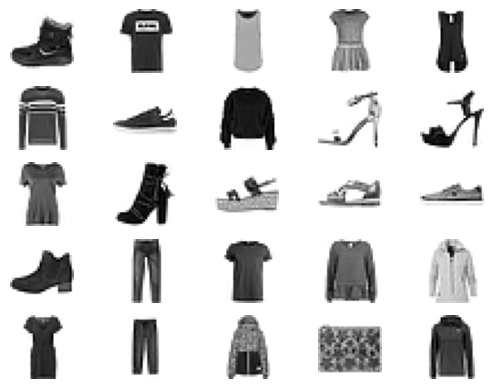

In [6]:
from keras.datasets import fashion_mnist

def load_real_samples():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32') / 255.0
    return X

samples = load_real_samples()

for i in range(25):
 pyplot.subplot(5, 5, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(samples[i], cmap='gray_r')
pyplot.show()

In [61]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset[:5000], latent_dim, 30, 128)


2/2 [==============================] - 0s 40ms/step
>1, 1/39, d=0.693, g=0.689
2/2 [==============================] - 0s 38ms/step
>1, 2/39, d=0.688, g=0.692
2/2 [==============================] - 0s 39ms/step
>1, 3/39, d=0.681, g=0.693
2/2 [==============================] - 0s 39ms/step
>1, 4/39, d=0.684, g=0.709
2/2 [==============================] - 0s 36ms/step
>1, 5/39, d=0.676, g=0.718
2/2 [==============================] - 0s 38ms/step
>1, 6/39, d=0.674, g=0.724
2/2 [==============================] - 0s 38ms/step
>1, 7/39, d=0.662, g=0.737
2/2 [==============================] - 0s 37ms/step
>1, 8/39, d=0.664, g=0.735
2/2 [==============================] - 0s 39ms/step
>1, 9/39, d=0.659, g=0.752
2/2 [==============================] - 0s 40ms/step
>1, 10/39, d=0.658, g=0.754
2/2 [==============================] - 0s 38ms/step
>1, 11/39, d=0.645, g=0.764
2/2 [==============================] - 0s 38ms/step
>1, 12/39, d=0.651, g=0.771
2/2 [==============================] - 0s 38ms/st

/Users/izzy/.pyenv/versions/3.8.15/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 39ms/step
>11, 1/39, d=0.665, g=0.830
2/2 [==============================] - 0s 42ms/step
>11, 2/39, d=0.658, g=0.819
2/2 [==============================] - 0s 45ms/step
>11, 3/39, d=0.644, g=0.796
2/2 [==============================] - 0s 42ms/step
>11, 4/39, d=0.656, g=0.828
2/2 [==============================] - 0s 45ms/step
>11, 5/39, d=0.658, g=0.838
2/2 [==============================] - 0s 44ms/step
>11, 6/39, d=0.675, g=0.846
2/2 [==============================] - 0s 42ms/step
>11, 7/39, d=0.656, g=0.853
2/2 [==============================] - 0s 61ms/step
>11, 8/39, d=0.656, g=0.827
2/2 [==============================] - 0s 39ms/step
>11, 9/39, d=0.665, g=0.844
2/2 [==============================] - 0s 41ms/step
>11, 10/39, d=0.650, g=0.836
2/2 [==============================] - 0s 42ms/step
>11, 11/39, d=0.664, g=0.835
2/2 [==============================] - 0s 39ms/step
>11, 12/39, d=0.651, g=0.841
2/2 [==============================] 

2/2 [==============================] - 0s 38ms/step
>21, 1/39, d=0.684, g=0.774
2/2 [==============================] - 0s 44ms/step
>21, 2/39, d=0.708, g=0.752
2/2 [==============================] - 0s 48ms/step
>21, 3/39, d=0.705, g=0.767
2/2 [==============================] - 0s 46ms/step
>21, 4/39, d=0.716, g=0.739
2/2 [==============================] - 0s 47ms/step
>21, 5/39, d=0.706, g=0.729
2/2 [==============================] - 0s 44ms/step
>21, 6/39, d=0.698, g=0.689
2/2 [==============================] - 0s 46ms/step
>21, 7/39, d=0.712, g=0.679
2/2 [==============================] - 0s 47ms/step
>21, 8/39, d=0.697, g=0.660
2/2 [==============================] - 0s 41ms/step
>21, 9/39, d=0.691, g=0.652
2/2 [==============================] - 0s 42ms/step
>21, 10/39, d=0.710, g=0.649
2/2 [==============================] - 0s 41ms/step
>21, 11/39, d=0.705, g=0.642
2/2 [==============================] - 0s 42ms/step
>21, 12/39, d=0.707, g=0.638
2/2 [==============================] 

## GAN - Your dataset

Find a dataset by yourself and create new instances with GAN. Document your observations. 

In [23]:
# https://www.kaggle.com/code/amirhosseinmirzaie/anime-character-generation-gan
from keras.utils import image_dataset_from_directory
from keras import layers, Model
import tensorflow as tf

image_size = 64
latent_size = 128
batch_size = 128
epochs = 25
lr = 0.0002

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()
generator = build_generator()
generator.summary()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

anime_faces = image_dataset_from_directory(directory="./anime-faces-images/", image_size=(64,64), batch_size=64, label_mode=None)
train_dataset = anime_faces.map(lambda x: (x - 127.5) / 127.5)
train_dataset = train_dataset.take(100)

print(len(train_dataset))

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


for epoch in range(epochs):
    print("epoch", epoch)
    batch_count = 0  
    for image_batch in train_dataset:
        batch_count += 1
        print("\nBatch", batch_count)
        train_step(image_batch)
    if epoch == epochs - 1:
        generator.save("anime-faces")

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_80 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_81 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 16, 16, 128)     

Found 63565 files belonging to 1 classes.
100
epoch 0

Batch 1

Batch 2

Batch 3

Batch 4

Batch 5

Batch 6

Batch 7

Batch 8

Batch 9

Batch 10

Batch 11

Batch 12

Batch 13

Batch 14

Batch 15

Batch 16

Batch 17

Batch 18

Batch 19

Batch 20

Batch 21

Batch 22

Batch 23

Batch 24

Batch 25

Batch 26

Batch 27

Batch 28

Batch 29

Batch 30

Batch 31

Batch 32

Batch 33

Batch 34

Batch 35

Batch 36

Batch 37

Batch 38

Batch 39

Batch 40

Batch 41

Batch 42

Batch 43

Batch 44

Batch 45

Batch 46

Batch 47

Batch 48

Batch 49

Batch 50

Batch 51

Batch 52

Batch 53

Batch 54

Batch 55

Batch 56

Batch 57

Batch 58

Batch 59

Batch 60

Batch 61

Batch 62

Batch 63

Batch 64

Batch 65

Batch 66

Batch 67

Batch 68

Batch 69

Batch 70

Batch 71

Batch 72

Batch 73

Batch 74

Batch 75

Batch 76

Batch 77

Batch 78

Batch 79

Batch 80

Batch 81

Batch 82

Batch 83

Batch 84

Batch 85

Batch 86

Batch 87

Batch 88

Batch 89

Batch 90

Batch 91

Batch 92

Batch 93

Batch 94

Batch 95

Batc

INFO:tensorflow:Assets written to: amk/assets


INFO:tensorflow:Assets written to: amk/assets


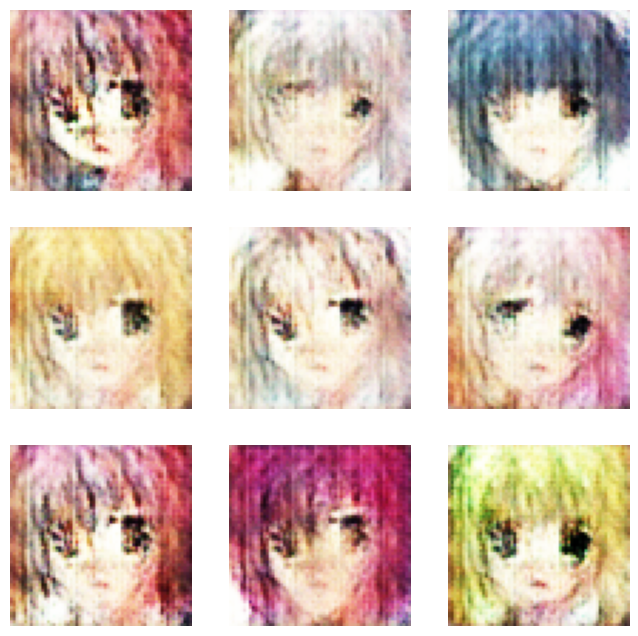

In [25]:
from numpy import clip

num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = clip(sample_images, 0, 1)  # Clip values to [0, 1]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.savefig('generated_anime-faces.png')
plt.show()

